# Regression
## Create the data

In [1]:
import random
import torch
from torch import nn, optim
import math
from IPython import display

In [2]:
from res.plot_lib import plot_data, plot_model, set_default
from matplotlib import pyplot as plt

In [3]:
set_default()

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
seed = 1
random.seed(seed)
torch.manual_seed(seed)
N = 1000  # num_samples_per_class
D = 1  # dimensions
C = 1  # num_classes
H = 100  # num_hidden_units

In [6]:
X = torch.unsqueeze(torch.linspace(-1, 1, 100), dim=1).to(device)
y = X.pow(3) + 0.3 * torch.rand(X.size()).to(device)

In [7]:
print("Shapes:")
print("X:", tuple(X.size()))
print("y:", tuple(y.size()))

Shapes:
X: (100, 1)
y: (100, 1)


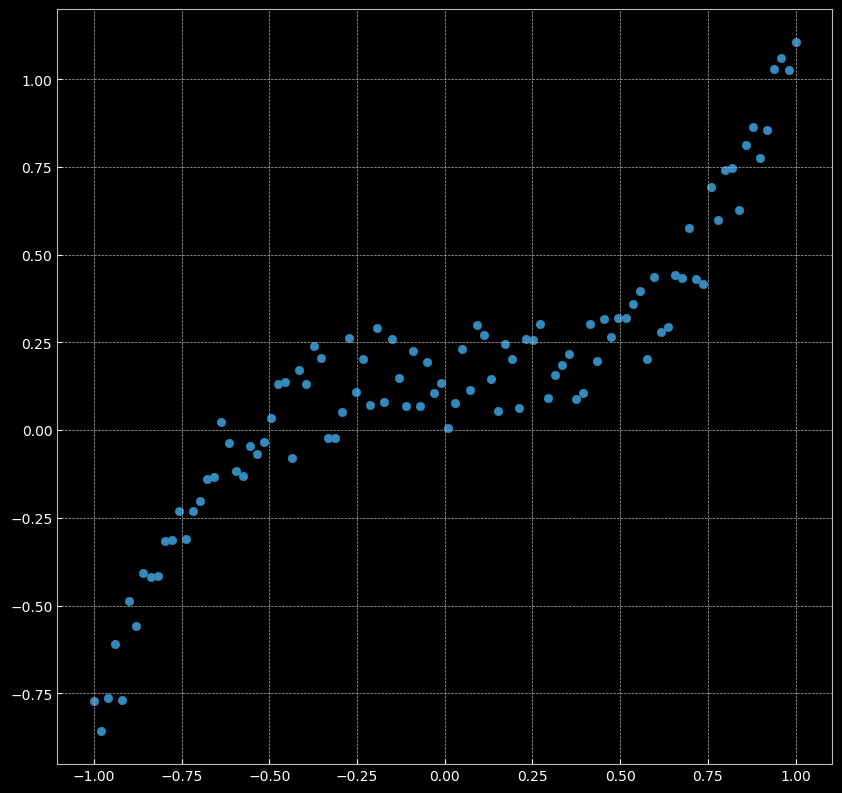

In [8]:
plt.scatter(X.cpu().numpy(), y.cpu().numpy())
plt.axis('equal');

## Linear model

In [9]:
learning_rate = 1e-3
lambda_l2 = 1e-5

In [10]:
# nn package to create our linear model
# each Linear module has a weight and bias
model = nn.Sequential(
    nn.Linear(D, H),
    nn.Linear(H, C)
)
model.to(device) # Convert to CUDA

# nn package also has different loss functions.
# we use MSE loss for our regression task
criterion = torch.nn.MSELoss()

# we use the optim package to apply
# stochastic gradient descent for our parameter updates
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=lambda_l2) # built-in L2

# Training
for t in range(1000):
    
    # Feed forward to get the logits
    y_pred = model(X)
    
    # Compute the loss (MSE)
    loss = criterion(y_pred, y)
    print("[EPOCH]: %i, [LOSS or MSE]: %.6f" % (t, loss.item()))
    display.clear_output(wait=True)
    
    # zero the gradients before running
    # the backward pass.
    optimizer.zero_grad()
    
    # Backward pass to compute the gradient
    # of loss w.r.t our learnable params. 
    loss.backward()
    
    # Update params
    optimizer.step()

[EPOCH]: 999, [LOSS or MSE]: 0.029701


In [11]:
# Plot trained model
print(model)

Sequential(
  (0): Linear(in_features=1, out_features=100, bias=True)
  (1): Linear(in_features=100, out_features=1, bias=True)
)


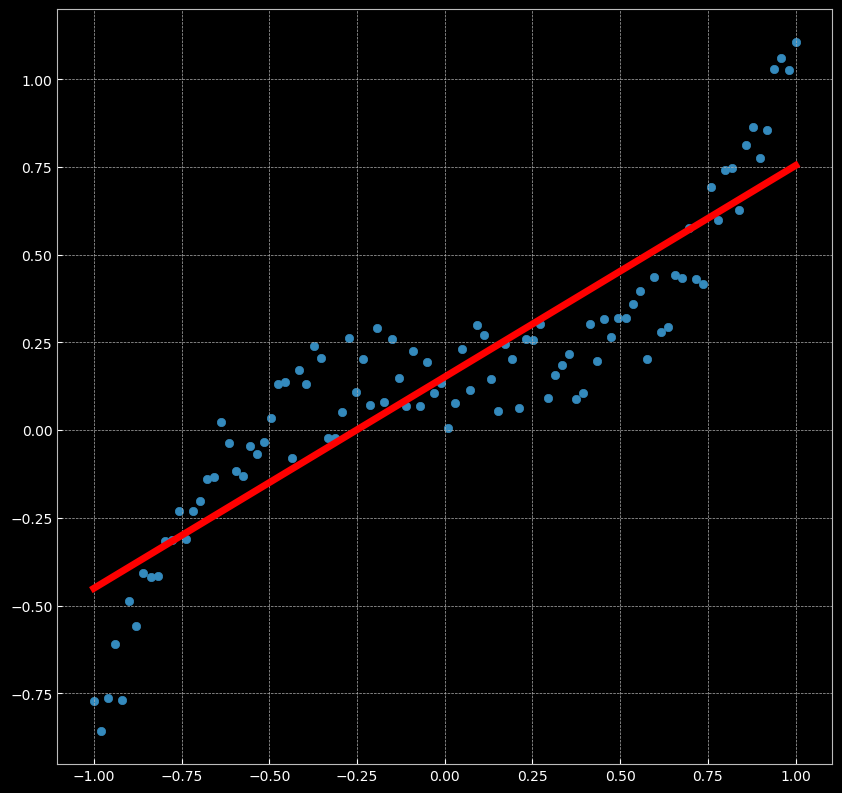

In [12]:
plt.scatter(X.data.cpu().numpy(), y.data.cpu().numpy())
plt.plot(X.data.cpu().numpy(), y_pred.data.cpu().numpy(), 'r-', lw=5)
plt.axis('equal');

## Two-layered network

In [13]:
learning_rate = 1e-3
lambda_l2 = 1e-5

In [14]:
# Number of networks
n_networks = 10
models = list()
y_pretrain = list()

# nn package also has different loss functions.
# we use MSE for a regression task
criterion = torch.nn.MSELoss()

for mod in range(n_networks):
    # nn package to create our linear model
    # each Linear module has a weight and bias
    model = nn.Sequential(
        nn.Linear(D, H),
        nn.ReLU() if mod < n_networks // 2 else nn.Tanh(),
        nn.Linear(H, C)
    )
    model.to(device)
    
    # Append models
    models.append(model)

    # we use the optim package to apply
    # ADAM for our parameter updates
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=lambda_l2) # built-in L2

    # e = 1.  # plotting purpose

    # Training
    for t in range(1000):

        # Feed forward to get the logits
        y_pred = model(X)
        
        # Append pre-train output
        if t == 0:
            y_pretrain.append(y_pred.detach())

        # Compute the loss and accuracy
        loss = criterion(y_pred, y)
        print(f"[MODEL]: {mod + 1}, [EPOCH]: {t}, [LOSS]: {loss.item():.6f}")
        display.clear_output(wait=True)

        # zero the gradients before running
        # the backward pass.
        optimizer.zero_grad()

        # Backward pass to compute the gradient
        # of loss w.r.t our learnable params. 
        loss.backward()

        # Update params
        optimizer.step()

[MODEL]: 10, [EPOCH]: 988, [LOSS]: 0.007616


In [15]:
print(models[0], models[-1])

## Predictions: Before Training

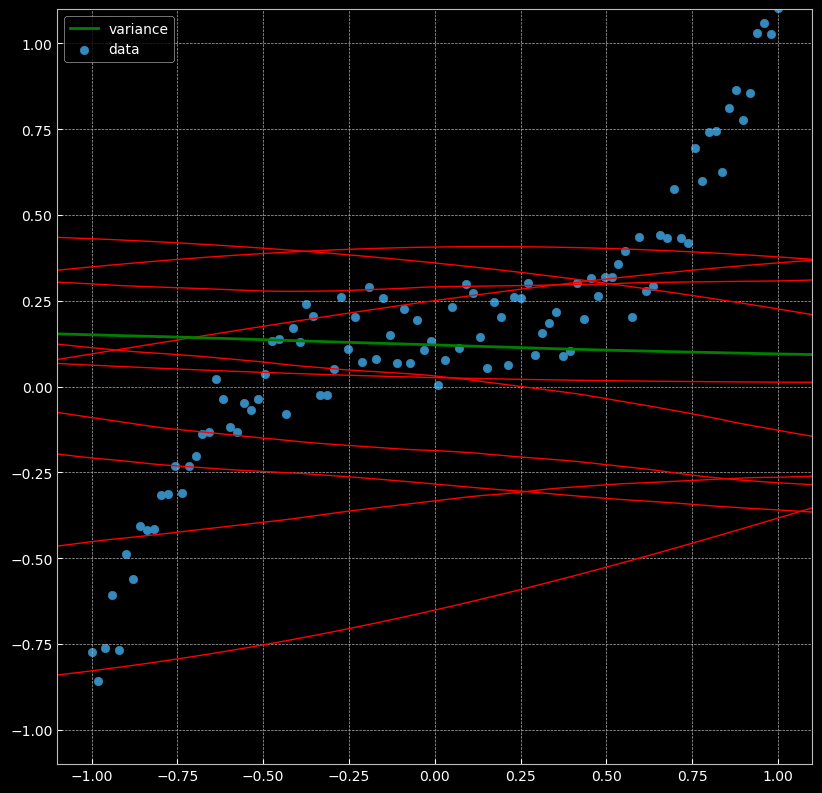

In [16]:
for y_pretrain_idx in y_pretrain:
    # New X that ranges from -5 to 5 instead of -1 to 1
    X_new = torch.unsqueeze(torch.linspace(-2, 2, 100), dim=1)
        
    plt.plot(X_new.numpy(), y_pretrain_idx.cpu().numpy(), 'r-', lw=1)

plt.scatter(X.cpu().numpy(), y.cpu().numpy(), label='data')
plt.axis('square')
plt.axis((-1.1, 1.1, -1.1, 1.1));
y_combo = torch.stack(y_pretrain)
plt.plot(X_new.numpy(), y_combo.var(dim=0).cpu().numpy(), 'g', label='variance');
plt.legend()

## Predictions: After Training

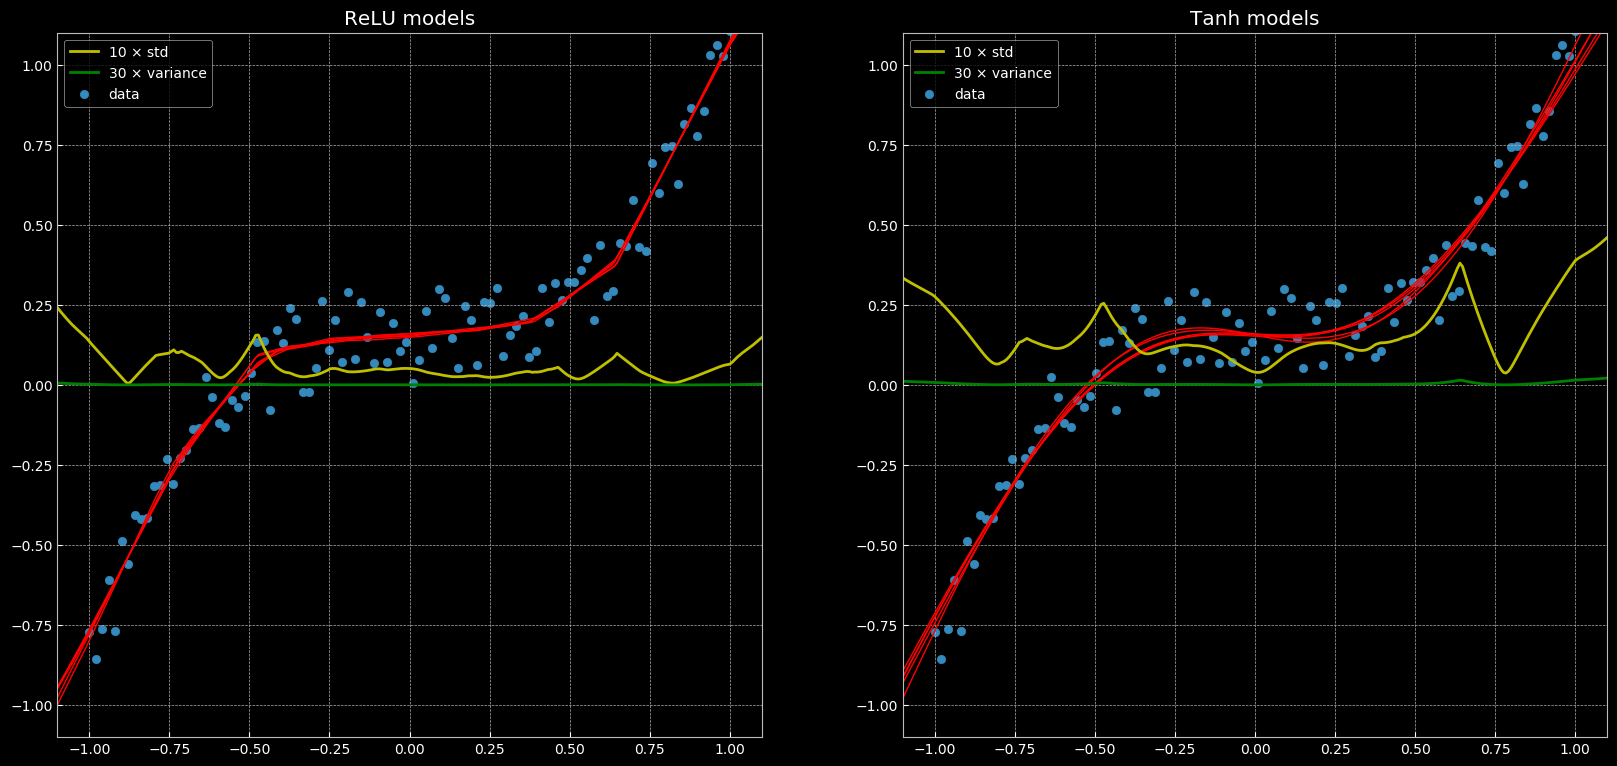

In [17]:
y_pred = list()
relu_models = models[:n_networks // 2]
tanh_models = models[n_networks // 2:]
plt.figure(figsize=(20, 10))

def dense_prediction(models, non_linearity, zoom):
    plt.subplot(1, 2, 1 if non_linearity == 'ReLU' else 2)
    for model in models:
        # New X that ranges from -5 to 5 instead of -1 to 1
        X_new = torch.unsqueeze(torch.linspace(-4, 4, 1001), dim=1).to(device)

        # Getting predictions from input
        with torch.no_grad():
            y_pred.append(model(X_new))

        plt.plot(X_new.cpu().numpy(), y_pred[-1].cpu().numpy(), 'r-', lw=1)
    plt.scatter(X.cpu().numpy(), y.cpu().numpy(), label='data')
    plt.axis('square')
    plt.axis(torch.tensor((-1.1, 1.1, -1.1, 1.1)) * zoom);
    y_combo = torch.stack(y_pred)
    plt.plot(X_new.cpu().numpy(), 10 * y_combo.var(dim=0).cpu().sqrt().numpy(), 'y', label='10 × std')
    plt.plot(X_new.cpu().numpy(), 10 * y_combo.var(dim=0).cpu().numpy(), 'g', label='30 × variance')
    plt.legend()
    plt.title(non_linearity + ' models')

z = 1  # try 1 or 4
dense_prediction(relu_models, 'ReLU', zoom=z)
dense_prediction(tanh_models, 'Tanh', zoom=z)